In [78]:
import pandas as pd
import os
from scipy.stats import pearsonr
import json
import matplotlib.pyplot as plt
import numpy as np

In [79]:
def read_quatrics(file_path):
    # read csv file
    with open(file_path, 'r') as f:
        data = pd.read_csv(f)
        data = data.drop([0, 1])
        data = data.loc[:, 'Q1':'Q20']
    return data

In [80]:
def euclidean_distance_to_car_difference(x1, x2):
    # input:x1,x2: 1x8 np array
    # first 6 are cartesian state, last 2 are car position
    # calc x1 and x2 dist to car and return the difference
    x1_xyz = x1[:3]
    x2_xyz = x2[:3]
    x1_car = x1[6:]
    x2_car = x2[6:]
    # from xy to xyz
    x1_car = np.concatenate([x1_car, np.array([0.05])])
    x2_car = np.concatenate([x2_car, np.array([0.05])])
    dist1 = np.linalg.norm(x1_xyz - x1_car)
    dist2 = np.linalg.norm(x2_xyz - x2_car)
    return dist1 - dist2


In [81]:
csv_dir = "/home/aabl-lab/prob-rob-final/A-more-human-like-oracle/quatrics"
file_name = "qualtrics-values.csv"
file_path = os.path.join(csv_dir, file_name)
pd_data = read_quatrics(file_path)
# print(pd_data)
qualtircs_data = pd_data.apply(pd.to_numeric)
qualtircs_data = pd_data.T.to_numpy(dtype=int)
print(qualtircs_data)

[[1 1 1 1 1 1 1 1 1 1 1]
 [2 1 1 1 1 1 2 2 1 1 2]
 [6 5 5 3 5 5 5 5 6 6 6]
 [1 1 3 1 4 2 1 1 5 2 1]
 [4 4 1 2 1 4 3 4 1 3 2]
 [7 7 2 5 1 7 7 7 2 3 1]
 [2 1 3 3 3 3 3 1 1 1 3]
 [4 3 2 1 1 4 3 3 1 2 2]
 [3 4 2 4 1 3 4 3 4 3 3]
 [3 4 3 3 1 2 3 4 5 4 4]
 [5 5 2 5 3 1 5 3 4 3 5]
 [2 1 4 1 1 5 4 4 1 2 2]]


In [82]:
project_path = os.path.dirname(os.path.dirname((os.path.abspath(''))))
dict_path = os.path.join(project_path, "dict_data")

data_list = []

for filename in os.listdir(dict_path):
    if filename.startswith('exp_exp_') and filename.endswith('.json'):
        file_path = os.path.join(dict_path, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            data_list.append(data)


print([len(data) for data in data_list])

hf_per_traj = []
delay_per_traj = []
reward_per_traj = []
reward_for_box_plt = [[],[],[],[],[]]
# loop over the data
for i, iter in enumerate(data_list):
    hf_values = []
    delay = []
    objective_rewards = []
    for j, data in enumerate(iter):
        if data['obs_before'] is None or data['obs_after'] is None or data['hf'] is None:
            continue
        if np.isnan(data['hf']["hf_value"]):
            continue
        hf_values.append(data['hf']["hf_value"])
        objective_rewards.append(euclidean_distance_to_car_difference(np.array(data['obs_before']["cartesian_state"]), np.array(data['obs_after']["cartesian_state"])))
        hf_value = int(data['hf']["hf_value"])
        reward_for_box_plt[hf_value + 2].append(euclidean_distance_to_car_difference(np.array(data['obs_before']["cartesian_state"]), np.array(data['obs_after']["cartesian_state"])))
        delay.append(data['hf']["delay"])
    hf_per_traj.append(np.array(hf_values))

    reward_per_traj.append(np.array(objective_rewards))
    delay_per_traj.append(delay)
# print(reward_per_traj)
# mean_objective_rewards = np.mean(reward_per_traj, axis=1)
# mean_hf_value = np.mean()
# print(hf_per_traj)

normalized_reward_per_traj = []
# normalize
max_element  = max([np.max(traj) for traj in reward_per_traj])
for i in range(len(reward_per_traj)):
    traj_i = reward_per_traj[i]
    traj_i = traj_i / max_element
    normalized_reward_per_traj.append(traj_i)



[17, 23, 35, 39, 22, 25, 22, 28, 29, 17, 24]


In [83]:
average_delay_per_traj = [] 
for delay_traj in delay_per_traj:
    delay_traj = np.array(delay_traj)
    average_delay_per_traj.append(np.mean(delay_traj[~np.isnan(delay_traj)]))

In [84]:
for i in range(len(qualtircs_data)):
    correlation, _ = pearsonr(qualtircs_data[i], average_delay_per_traj)
    print(correlation)

nan
0.12072978323693702
0.25644564382476265
0.04701391809753534
0.48368971799068905
0.4479436129672211
-0.24657879343897937
0.5204890632291775
0.07496764435244697
-0.10378256628432223
-0.07328134582558354
0.09582548298863025


/tmp/ipykernel_3309/3045493864.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(qualtircs_data[i], average_delay_per_traj)


11
11


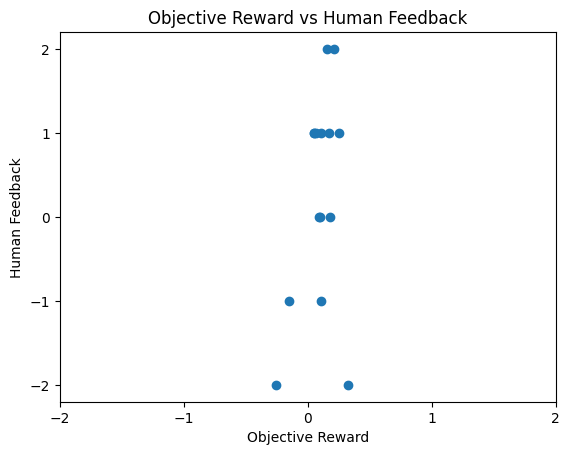

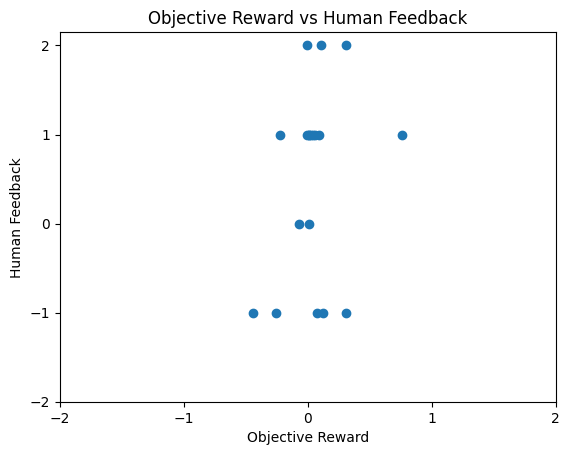

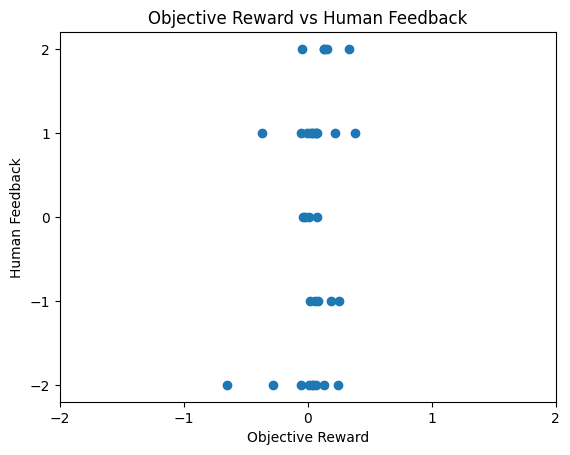

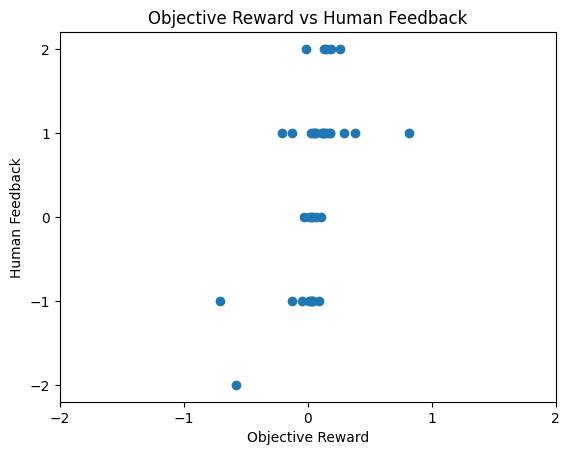

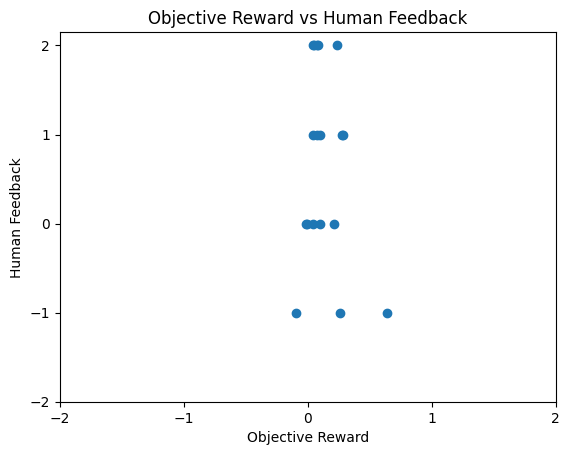

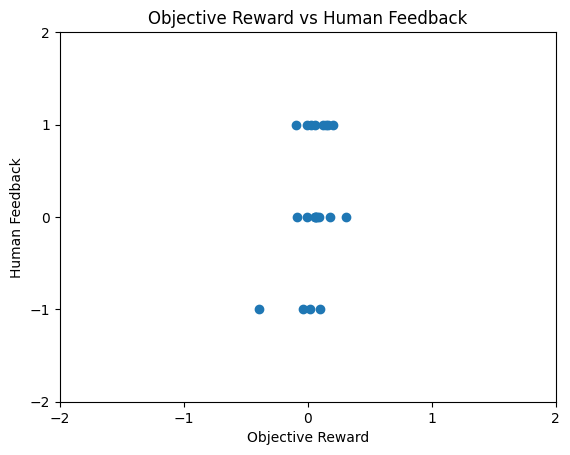

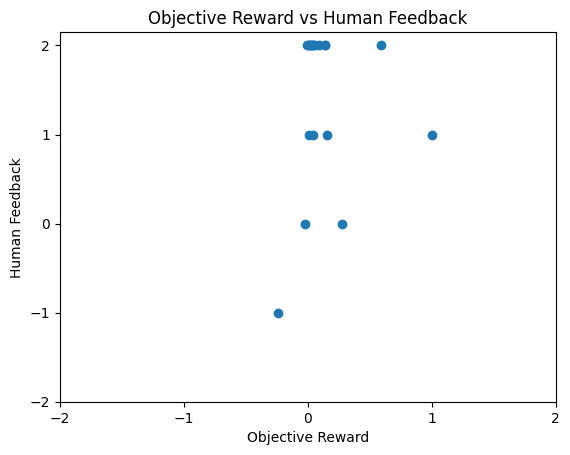

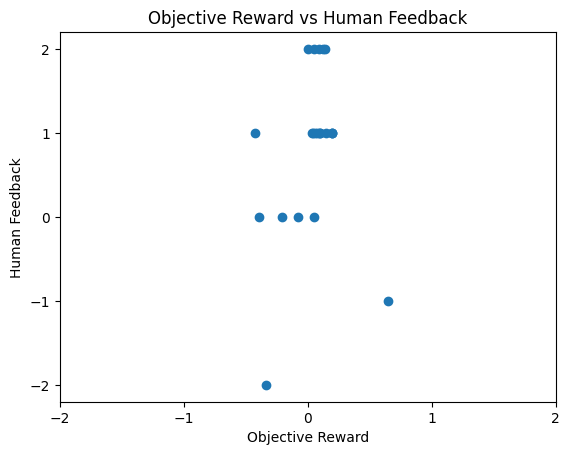

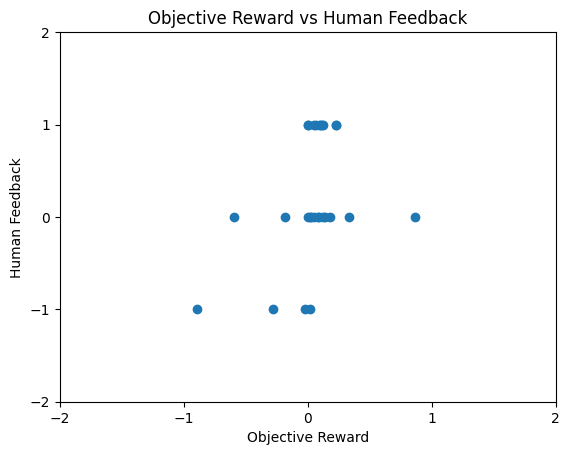

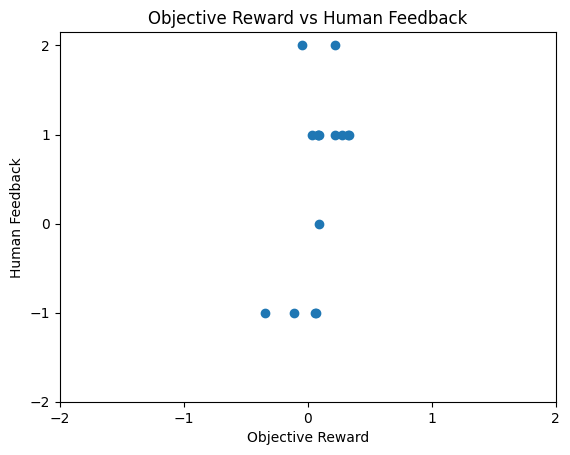

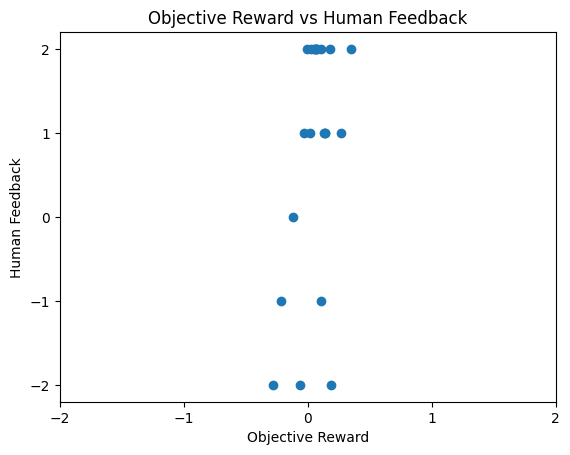

In [85]:
print(len(normalized_reward_per_traj))
print(len(hf_per_traj))

for i in range(len(reward_per_traj)):
    plt.scatter(normalized_reward_per_traj[i], hf_per_traj[i])
    plt.title('Objective Reward vs Human Feedback')
    plt.ylabel('Human Feedback')
    plt.xlabel('Objective Reward')
    plt.xticks([-2, -1, 0, 1, 2])
    plt.yticks([-2, -1, 0, 1, 2])
    plt.show()